# [Lab 02 - Implementacja propagacji wstecznej błędu](http://pages.mini.pw.edu.pl/~karwowskij/mioad/lab-sieci.html#org5e8c9e3)

W ramach tego laboratorium trzeba zaimplementować **uczenie sieci neuronowej propagacją wsteczną błędu**.
Aby sprawdzić implementację, należy wykonać uczenie na prostych danych do uczenia dostarczonych na zajęciach.
Następnie należy zaimplementować **metodę wizualizacji wartości wag sieci** w kolejnych iteracjach i, w przypadku gdy nie udaje się nauczyć sieci, spróbować wykorzystać te wizualizacje do ustalenia przyczyny problemu.
Zaimplementować wersję z aktualizacją wag po prezentacji wszystkich wzorców i wersję z aktualizacją po prezentacji kolejnych porcji (batch).
Porównać szybkość uczenia dla każdego z wariantów.

Rozważyć trzy warianty inicjowania wag do procesu uczenia wagi z rozkładu jednostajnego na przedziale [0,1].
Opcjonalnie zaimplementować inną metodą inicjowania wag.
Albo metodę He albo Xavier.

Przetestować uczenie sieci na następujących zbiorach:
- square-simple (jeśli sieć nie jest w stanie się nauczyć tej funkcji to coś jest bardzo źle zrobione),
- steps-small,
- multimodal-large.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics



## Model

In [169]:
import numpy as np


class MLP:
    def __init__(self, layers, weights, biases):
        self.layers = layers
        self.weights = weights
        self.biases = biases



    def feedforward(self, x):
        # return the feedforward value for x
        w = self.weights
        b = self.biases

        a = np.copy(x)
        z = []
        activations = [a]
        for i in range(len(w) -1):
            z.append(w[i] @ a + b[i])
            a = self.sigmoid(z[-1])
            activations.append(a)
        
        z.append(w[-1] @ a + b[-1])
        a = z[-1]    
        activations.append(a)
        
        
        return (z, activations)

    def backpropagation(self, y, z, activations):
        deltas = [None] * len(self.weights)

        deltas[-1] = y - activations[-1]

        for i in reversed(range(len(deltas) - 1)):
            deltas[i] = self.weights[i + 1].T @ deltas[i + 1] * self.sigmoidGradient(z[i])

        m = y.shape[1]

        derivative_b = [None] * len(deltas)
        derivative_w = [None] * len(deltas)

        for i, d in enumerate(deltas):
            derivative_w[i] = d @ activations[i].T / m
            derivative_b[i] = d @ np.ones(m).reshape(-1,1) / m

        return derivative_w, derivative_b

    def train(self, x, y, batch_size=10, epochs=100, alpha=0.01):
        
        # shuffle data:
        p = np.random.permutation(len(y))
        x = x[p]
        y = y[p]

        for e in range(epochs):
            i = 0
            while (i < len(y)):
                x_batch = x[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                i = i + batch_size
                z, activations = self.feedforward(x_batch)
                derivative_w, derivative_b = self.backpropagation(y_batch, z, activations)

                for j, weight in enumerate(self.weights):
                    self.weights[j] = weight + alpha * derivative_w[j]

                for j, bias in enumerate(self.biases):
                    self.biases[j] = bias + alpha * derivative_b[j]
            
            print(f"Error in epoch {e} = {np.linalg.norm(activations[-1] - y_batch)}", end = "\r")

    @staticmethod
    def sigmoid(x):
        return np.exp(x) / (1 + np.exp(x))

    @staticmethod
    def sigmoidGradient(x):
        def sigmoid(x):
            return np.exp(x) / (1 + np.exp(x))

        return sigmoid(x) * (1 - sigmoid(x))



In [170]:
def normalize_train_test(train, test): 
    def normalize(x):
        return (x - np.mean(x))/np.std(x)
    
    x = normalize(np.array(train['x']).reshape(1,-1))
    y = normalize(np.array(train['y']).reshape(1,-1))
    x_test = normalize(np.array(test['x']).reshape(1,-1)) 
    y_test = normalize(np.array(test['y']).reshape(1,-1))
    
    return x, y, x_test, y_test

# Testowanie modelu na danych
## Square simple

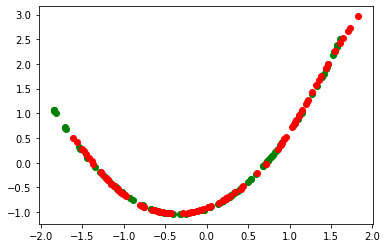

In [171]:
train_df = pd.read_csv('../data/square-simple-training.csv', index_col=0)
test_df = pd.read_csv('../data/square-simple-test.csv', index_col=0)

x, y, x_test, y_test = normalize_train_test(train_df, test_df)

layers=[1, 5, 1]
weights = []
biases = []

for i in range(len(layers) - 1):
    weights.append(np.random.randn(layers[i + 1], layers[i]))
    biases.append(np.random.randn(layers[i + 1], 1))

mlp = MLP(
    layers, 
    weights,
    biases    
    #draw_weights=True  # sieć można narysować wykorzystując networkx, matplotlib lub inne biblioteki
)



mlp.train(x, y, epochs=10000, batch_size = 100, alpha=0.1)

_, activations = mlp.feedforward(x_test)


plt.scatter(x, y, color='green')
plt.scatter(x_test, activations[-1], color='red')

## multimodal-small

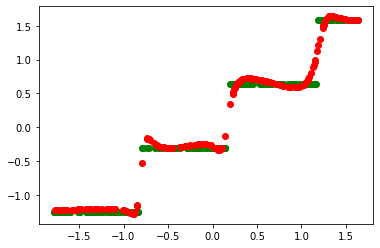

In [174]:
train_df = pd.read_csv('../data/multimodal-small-training.csv', index_col=0)
test_df = pd.read_csv('../data/multimodal-small-test.csv', index_col=0)

layers=[1, 5,5, 1]
weights = []
biases = []

for i in range(len(layers) - 1):
    weights.append(np.random.randn(layers[i + 1], layers[i]))
    biases.append(np.random.randn(layers[i + 1], 1))

mlp = MLP(
    layers,  # dobrać ręcznie w zależności od problemu
    weights,
    biases    
    #draw_weights=True  # sieć można narysować wykorzystując networkx, matplotlib lub inne biblioteki
)

x, y, x_test, y_test = normalize_train_test(train_df, test_df)


mlp.train(x, y, epochs=100000, batch_size = 100, alpha=1)

_, activations = mlp.feedforward(x_test)


plt.scatter(x, y, color='green')
plt.scatter(x_test, activations[-1], color='red')

## multimodal-large

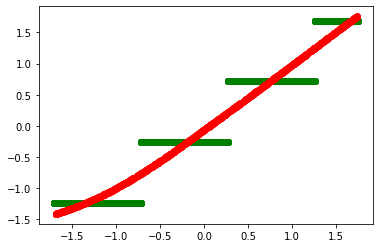

In [173]:
train_df = pd.read_csv('../data/multimodal-large-training.csv', index_col=0)
test_df = pd.read_csv('../data/multimodal-large-test.csv', index_col=0)

layers=[1, 10,10, 1]
weights = []
biases = []

for i in range(len(layers) - 1):
    weights.append(np.random.uniform(-1, 1, size=layers[i + 1] * layers[i]).reshape(layers[i + 1], layers[i]))
    biases.append(np.random.uniform(-1, 1, size=layers[i + 1]).reshape(layers[i + 1], 1))

mlp = MLP(
    layers,  # dobrać ręcznie w zależności od problemu
    weights,
    biases    
    #draw_weights=True  # sieć można narysować wykorzystując networkx, matplotlib lub inne biblioteki
)

x, y, x_test, y_test = normalize_train_test(train_df, test_df)


mlp.train(x, y, epochs=20000, batch_size = 20, alpha=0.1)

_, activations = mlp.feedforward(x_test)


plt.scatter(x, y, color='green')
plt.scatter(x_test, activations[-1], color='red')

# Szybkość i jakość trenowania a batch size 
Aby przeprowadzić ten eksperyment weźmy prosty zbiór 

In [ ]:
%%timeit
train_df = pd.read_csv('../data/square-simple-training.csv', index_col=0)
test_df = pd.read_csv('../data/square-simple-test.csv', index_col=0)

x, y, x_test, y_test = normalize_train_test(train_df, test_df)

layers=[1, 5, 1]
weights = []
biases = []

for i in range(len(layers) - 1):
    weights.append(np.random.randn(layers[i + 1], layers[i]))
    biases.append(np.random.randn(layers[i + 1], 1))

mlp = MLP(
    layers, 
    weights,
    biases    
    #draw_weights=True  # sieć można narysować wykorzystując networkx, matplotlib lub inne biblioteki
)



mlp.train(x, y, epochs=1000, batch_size = len(y), alpha=0.1)

_, activations = mlp.feedforward(x_test)


plt.scatter(x, y, color='green')
plt.scatter(x_test, activations[-1], color='red')

Training y_mean: 21, y_std: 81.93289937503738
Epoch 1/5: |██████████████████████████████████████████████████| 100.0% 
Training - average error: 38.69970084406522, standard deviation: 32.76589076660245
Epoch 2/5: |██████████████████████████████████████████████████| 100.0% 
Training - average error: 34.73402205648583, standard deviation: 18.238937167694026
Epoch 3/5: |██████████████████████████████████████████████████| 100.0% 
Training - average error: 30.028710270696877, standard deviation: 14.585176078947862
Epoch 4/5: |██████████████████████████████████████████████████| 100.0% 
Training - average error: 25.36589129114717, standard deviation: 11.897952730759235
Epoch 5/5: |██████████████████████████████████████████████████| 100.0% 
Training - average error: 21.82493932396329, standard deviation: 10.631029927885423


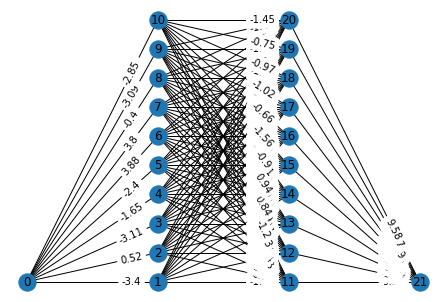

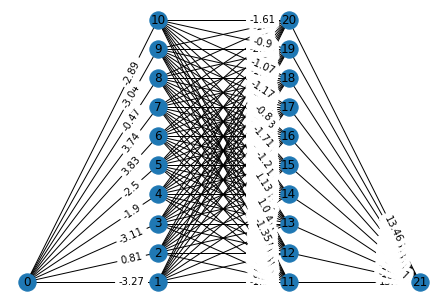

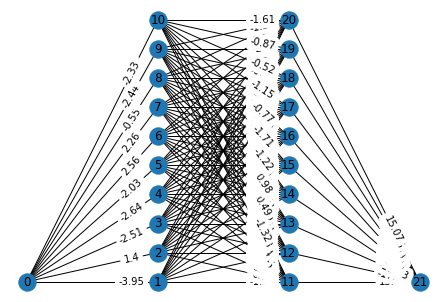

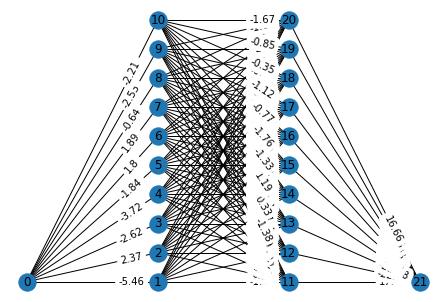

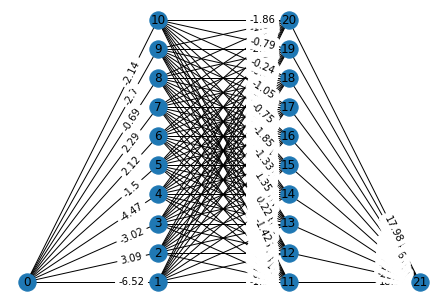

In [15]:
result = mlp.train_regression(
    train_data=train_data,
    epochs=5,  # dobrać ręcznie w zależności od problemu
    batch_size=20,  # dobrać ręcznie w zależności od problemu i porównać z batch_size=len(x)
    learning_rate=1e-3,  # dobrać ręcznie w zależności od problemu
)

In [16]:
train_df['y_pred'] = train_df['x'].apply(lambda x_i: mlp.predict_regression(x_i))

<ipython-input-16-9aa07bae430a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['y_pred'] = train_df['x'].apply(lambda x_i: mlp.predict_regression(x_i))


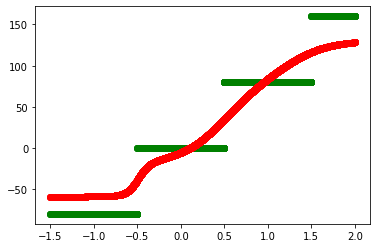

In [17]:
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], train_df['y_pred'], color='red')

In [18]:
# mae można policzyć na zbiorze treningowym i walidacyjnym i omówić różnice w sprawozdaniu
metrics.mean_absolute_error(train_df['y'], train_df['y_pred'])

21.824939323963285

## Podsumowanie
- wnioski na podstawie wizualiacji wag sieci podczas uczenia
- porównać szybkość uczenia na całym zbiorze oraz w podejściu batchowym
- porównać trzy warianty inicjalizacji wag z rozkładu jednostajnego na przedziale [0, 1] (opcjonalnie można też sprawdzić metody He lub Xavier)
- zwalidować model na 3 zbiorach: square-simple, steps-small, multimodal-large